In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import choice

%matplotlib inline

https://www.neverstopbuilding.com/blog/2013/12/13/tic-tac-toe-understanding-the-minimax-algorithm13  
https://github.com/khpeek/Q-learning-Tic-Tac-Toe

### Outline:
- Game  
-- instantiates new Players, or accesses provided Players    
-- instantiates the Board  
-- keeps track of whose turn it is  
-- passes Board to Players when asking for a move, then updates Board with move  
-- keeps track of game outcome
- Board  
-- the board that is updated over the course of the game
- Player  
-- can exist on its own outside of Game  
-- has a policy  
-- selects a move  
-- can calculate if a board state is a win/loss/tie
-- remembers Board state from Player's previous move, and updates policy if needed  
-- if set to 'human', the Player just asks the human for input for each move

# Classes

In [1]:
class ttt_board(object):
    
    def __init__(self):
        self.spaces = ['_'] * 9
        
    def __str__(self):
        # Allow for printing of board in human-readable format
        return '%s\n%s\n%s\n' % (' '.join(self.spaces[:3]), ' '.join(self.spaces[3:6]), ' '.join(self.spaces[6:]))
    
    def update(self, ix, mark):
        """
        Updates the board with a new X or O.
        """
        self.spaces[ix] = mark

    
class ttt_player(object):
    
    def __init__(self, player_type, mark, epsilon=.9, alpha=.1):
        self.player_type = player_type
        self.mark = mark
        self.board_vals = [2**i for i in range(9)]
        if player_type == 'computer':
            self.policy = dict()
            self.alpha = alpha            # learning rate
            self.epsilon = epsilon        # exploration rate
            self.prev_state = None
    
    
    def __str__(self):
        return 'Player %s' % self.mark
    
    
    def set_epsilon(self, epsilon):
        """
        Sets the player's exploration rate. This is the rate at which the player explores move options that
        *don't* have the highest win probability based on the player's current policy.
        """
        self.epsilon = epsilon
    
    
    def get_player_total(self, state):
        """
        Returns a total for each player based on values I've assigned to each space on the board.
        This enables us to easily see if someone has won the game.
        """
        total = 0
        for i, x in enumerate(state):
            if x == self.mark:
                total += self.board_vals[i]
        return total
    
    
    def get_move_outcome(self, state):
        """
        Informs the player that the given state is a win, draw, or none of the above. Uses bitwise operations to
        translate the board state into an indication of a win. See explanation here:
        http://mamallamacoding.blogspot.com/2014/03/making-tictactoe-with-object-oriented.html
        """
        win_totals = [7, 56, 448, 73, 146, 292, 273, 84]
        total = self.get_player_total(state)
        for val in win_totals:
            if total & val == val: # bitwise operation!
                return 'win'
        if '_' not in state:
            return 'draw'
        return None
    
    
    def get_prob_from_policy(self, state):
        """
        This function returns a player's current understanding of its probability of winning from a given
        board state. If the player has never seen this state before, the function fills the player's policy with
        a 1 if it's a win state (e.g. three X's in a row), a .5 if it's a draw state, or a .5 if it's an unknown
        state prior to the end of the game.
        
        (A player will never store a lose state in its policy [e.g. three O's in a row if you are player X] 
        because the player will not make any more moves after it has lost.)
        """
        state = tuple(state)
        if state in self.policy:
            return self.policy[state]
        
        outcome = self.get_move_outcome(state)
        if outcome == 'win':
            self.policy[state] = 1
        elif outcome == 'draw':
            self.policy[state] = .5
        else:                       # Fill with .5 if winner hasn't been decided yet
            self.policy[state] = .5
        return self.policy[state]

                                   
    def update_policy(self, current_win_prob, board, state):
        """
        Updates the win probability of a previous state based on the win probability of the current state.
        """
        prev_state = tuple(self.prev_state)
        prev_win_prob = self.policy[prev_state]
        self.policy[prev_state] = prev_win_prob + self.alpha*(current_win_prob - prev_win_prob)
        
        
    def get_move(self, board):
        """
        Gets a move from a human or computer player.
        returns: index of the board space that the player wants to make an X or O in (ix from 0-8)
        """
        if self.player_type == 'human':
            while True:
                try:
                    row_index, col_index = eval(raw_input( \
                                "Enter the row and column you want to make a mark in, using the format x,y "))
                    # Get correct index in the board list, adjusting for 0-indexing
                    move_index = (row_index-1)*3 + col_index - 1
                    if board.spaces[move_index] == '_':
                        return move_index
                except:
                    pass
                print "Invalid move.\n"
        
        # Make Computer player decision
        state = board.spaces[:]
        possible_move_indices = [i for i, x in enumerate(state) if x == '_']
        
        if np.random.uniform() < self.epsilon:     # randomly choose a move with probability = epsilon
            move_index = choice(possible_move_indices)
            next_state = state[:]
            next_state[move_index] = self.mark
            _ = self.get_prob_from_policy(next_state) # I don't use the result, but this function fills the
                            # policy with a win probability for this state if this state key doesn't already exist
        
        else:               # Choose the best known move with probability = 1-epsilon
            max_prob = 0
            best_move_ixs = []
            for i in possible_move_indices:
                potential_state = state[:]
                potential_state[i] = self.mark
                prob = self.get_prob_from_policy(potential_state)
                if prob == max_prob:
                        best_move_ixs.append(i)
                if prob > max_prob:
                        best_move_ixs = [i]
                        max_prob = prob
            move_index = choice(best_move_ixs)
            if self.prev_state:
                self.update_policy(max_prob, board, state)  

        self.prev_state = state
        self.prev_state[move_index] = self.mark
        return move_index
                            
            
# Game object instantiates the board and human or CPU players
class ttt_game(object):
    
    def __init__(self, playerX, playerO, print_output = True):
        self.board = ttt_board()
        if isinstance(playerX, ttt_player):
            if playerX.mark == 'X':
                self.playerX = playerX
                self.playerX.prev_state = None
            else:
                raise ValueError('playerX must have player mark "X".')
        elif playerX == 'human':
            self.playerX = ttt_player('human', 'X')
        elif playerX == 'computer':
            self.playerX = ttt_player('computer', 'X')
        else:
            raise ValueError('playerX must be a ttt_player object, or it must be a string indicating "human" or "computer."')
          
        if isinstance(playerO, ttt_player):
            if playerO.mark == 'O':
                self.playerO = playerO
                self.playerO.prev_state = None
            else:
                raise ValueError('playerO must have player mark "O".')
        elif playerO == 'human':
            self.playerO = ttt_player('human', 'O')
        elif playerO == 'computer':
            self.playerO = ttt_player('computer', 'O')
        else:
            raise ValueError('playerO must be a ttt_player object, or it must be a string indicating "human" or "computer."')
               
        self.playerX_score = []
        self.playerO_score = []
        self.current_player = self.playerX
        self.print_output = print_output
        
        
    def set_print(self, print_output):
        """
        Sets the print_output attribute. If True, ttt_game will print the board at each move, say whose turn
        it is, and state the outcome of each game.
        print_output: True or False
        """
        self.print_output = print_output
    
    
    def take_a_turn(self):
        """
        Asks the current player to select its next move.
        """
        if self.print_output:
            print "%s's turn:" % self.current_player
        move_index = self.current_player.get_move(self.board)
        self.board.update(move_index, self.current_player.mark)
        if self.current_player == self.playerX:
            self.current_player = self.playerO
        else:
            self.current_player = self.playerX
        if self.print_output:
            print self.board
        
        
    def game_outcome(self):
        """
        Returns information on wins or ties, or returns None if the game is not yet over.
        """
        state = self.board.spaces
        win_totals = [7, 56, 448, 73, 146, 292, 273, 84]
        X_total = self.playerX.get_player_total(state)
        O_total = self.playerO.get_player_total(state)
        for val in win_totals:
            if X_total & val == val:        # Bitwise operation!
                self.playerX_score.append(1)
                self.playerO_score.append(0)
                return 'Player X wins!'
            if O_total & val == val:
                self.playerO_score.append(1)
                self.playerX_score.append(1)
                return 'Player O wins!'
        if '_' not in state:
            self.playerX_score.append(.5)
            self.playerO_score.append(.5)
            return 'The game is a tie!'
        return None

                                   
    def send_game_end_signal(self, outcome):
        """
        The "current player" is the player who took the penultimate turn. We send that player information on
        the game outcome, so that player can adjust its policy.
        """
        penultimate_player = self.current_player
        if outcome == 'The game is a tie!':
            win_prob = .5
        else:
            win_prob = 0
        if penultimate_player.player_type == 'computer':
            penultimate_player.update_policy(win_prob, self.board, self.board)   
    
    
    def play(self):
        """
        Plays a game of tic tac toe.
        """
        if self.print_output:
            print self.board
        outcome = self.game_outcome()
        while not (outcome):
            self.take_a_turn()
            outcome = self.game_outcome()
        self.send_game_end_signal(outcome)
        if self.print_output:
            print outcome
      
    
    def reset(self):
        """
        Resets board and certain player attributes in preparation for a new game.
        """
        self.board = ttt_board()
        self.playerX.prev_state = None
        self.playerO.prev_state = None
        self.current_player = self.playerX

 

# Helper functions

In [136]:
def print_board(state):
    """
    state: list of strings that indicates the board state
    """
    print '%s\n%s\n%s' % (' '.join(state[:3]), ' '.join(state[3:6]), ' '.join(state[6:]))
                          

def train_computer_players(player1, player2, n_games=200000, adj_p1_epsilon=True, adj_p2_epsilon=True):
    """
    Trains an "X" computer player and an "O" computer player on 200000 games of tic tac toe,
    with their exploration rate set to .9, in order to learn quickly.
    """
    if adj_p1_epsilon:
        player1.set_epsilon(.9)
    if adj_p2_epsilon:
        player2.set_epsilon(.9)
    game = ttt_game(player1, player2, print_output = False)
    for i in range(1, n_games+1):
        if i/float(n_games) >= .5:
            if i/float(n_games) >= .9:
                if adj_p1_epsilon:
                    player1.set_epsilon(0)
                if adj_p2_epsilon:
                    player2.set_epsilon(0)
            else:
                if adj_p1_epsilon:
                    player1.set_epsilon(.2)
                if adj_p2_epsilon:
                    player2.set_epsilon(.2)
        game.play()
        game.reset()
    return game
        

def test_computer(computer_player, n_games=3):
    """
    Used when a human wants to evaluate a computer player.
    This function plays n_games with a human versus the computer_player.
    """    
    computer_player.set_epsilon(0)
    if computer_player.mark == 'X':
        game = ttt_game(computer_player, 'human', print_output=True)
    if computer_player.mark == 'O':
        game = ttt_game('human', computer_player, print_output=True)
    for i in range(n_games):
        game.play()
        game.reset()
        
        
def explore_policy(state, player):
    """
    Given a board state, this function shows all possible next moves for a player and the probability of winning
    from those next moves, according to the player's policy.
    state: list of strings indicating the board state
    player: ttt_player object 
    """
    print_board(state)
    print 'Initial board state\n'
    possible_move_indices = [i for i, x in enumerate(state) if x == '_']
    for i in possible_move_indices:
        potential_state = state[:]
        potential_state[i] = player.mark        
        print_board(potential_state)
        print 'Win probability = %.17f\n' % player.policy[tuple(potential_state)]
    
    

In [125]:
player1 = ttt_player('computer', 'X', epsilon=.9)
player2 = ttt_player('computer', 'O', epsilon=.9)

In [126]:
p1_2_game = train_computer_players(player1, player2)

In [7]:
state = ['X', '_', '_', '_', '_', '_', '_', '_', '_']
explore_policy(state, player2)

X _ _
_ _ _
_ _ _
Initial board state

X O _
_ _ _
_ _ _
Win probability = 0.71088598028021743

X _ O
_ _ _
_ _ _
Win probability = 0.78530149523849113

X _ _
O _ _
_ _ _
Win probability = 0.73033496234705231

X _ _
_ O _
_ _ _
Win probability = 0.93861786735411801

X _ _
_ _ O
_ _ _
Win probability = 0.76362258480081358

X _ _
_ _ _
O _ _
Win probability = 0.80887194029267040

X _ _
_ _ _
_ O _
Win probability = 0.75830780967204903

X _ _
_ _ _
_ _ O
Win probability = 0.82851672037580937



In [89]:
test_computer(player2)

_ _ _
_ _ _
_ _ _

Player X's turn:
Enter the row and column you want to make a mark in, using the format x,y 1,1
X _ _
_ _ _
_ _ _

Player O's turn:
X _ _
_ O _
_ _ _

Player X's turn:
Enter the row and column you want to make a mark in, using the format x,y 2,1
X _ _
X O _
_ _ _

Player O's turn:
X _ _
X O _
O _ _

Player X's turn:
Enter the row and column you want to make a mark in, using the format x,y 1,3
X _ X
X O _
O _ _

Player O's turn:
X O X
X O _
O _ _

Player X's turn:
Enter the row and column you want to make a mark in, using the format x,y 3,2
X O X
X O _
O X _

Player O's turn:
X O X
X O _
O X O

Player X's turn:
Enter the row and column you want to make a mark in, using the format x,y 2,3
X O X
X O X
O X O

The game is a tie!
_ _ _
_ _ _
_ _ _

Player X's turn:
Enter the row and column you want to make a mark in, using the format x,y 1,1
X _ _
_ _ _
_ _ _

Player O's turn:
X _ _
_ O _
_ _ _

Player X's turn:
Enter the row and column you want to make a mark in, using the

### Player 1 and Player 2 win stats

In [127]:
p1_2_scores = pd.DataFrame(p1_2_game.playerO_score)
p1_2_scores.columns = ['score']
p1_2_scores['not_loss'] = (p1_2_scores.score != 0).astype(int)
group_size = 2000
n_groups = len(p1_2_scores)/group_size
p1_2_scores['group'] = np.repeat(np.arange(n_groups), group_size)
p1_2_scores_agg = p1_2_scores.groupby('group').not_loss.transform(lambda x: x.sum()/float(x.shape[0]))

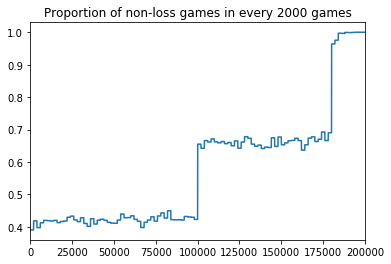

In [128]:
p1_2_scores_agg.plot()
plt.title('Proportion of non-loss games in every 2000 games')

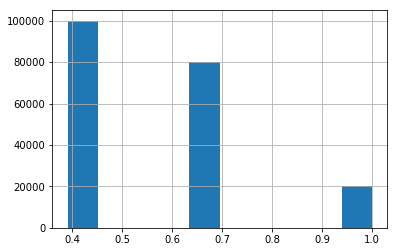

In [129]:
p1_2_scores_agg.hist()

In [130]:
player1.set_epsilon(0)
player2.set_epsilon(0)
p1_2_real_game = ttt_game(player1, player2, print_output = False)

In [131]:
for i in range(20000):
    p1_2_real_game.play()
    p1_2_real_game.reset()

In [132]:
p1_2_real_scores = pd.DataFrame(p1_2_real_game.playerO_score)
p1_2_real_scores.columns = ['score']
p1_2_real_scores['not_loss'] = (p1_2_real_scores.score != 0).astype(int)
group_size = 2000
n_groups = len(p1_2_real_scores)/group_size
p1_2_real_scores['group'] = np.repeat(np.arange(n_groups), group_size)
p1_2_real_scores_agg = p1_2_real_scores.groupby('group').not_loss.transform(lambda x: x.sum()/float(x.shape[0]))

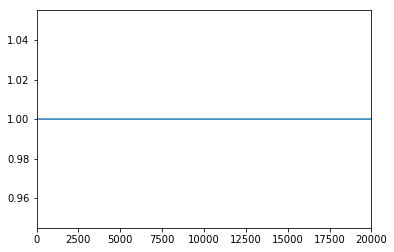

In [133]:
p1_2_real_scores_agg.plot()

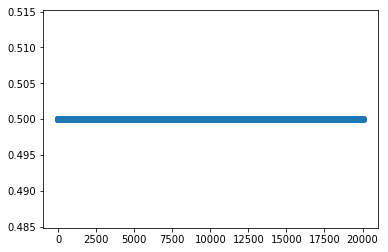

In [134]:
plt.scatter(np.arange(p1_2_real_scores.shape[0]), p1_2_real_scores.score)

### Player 3 win stats

In [135]:
player3 = ttt_player('computer', 'O', epsilon=.9)

In [137]:
player1.set_epsilon(0)
p1_3_game = train_computer_players(player1, player3, adj_p1_epsilon=False)

In [138]:
p1_3_scores = pd.DataFrame(p1_3_game.playerO_score)
p1_3_scores.columns = ['score']
p1_3_scores['not_loss'] = (p1_3_scores.score != 0).astype(int)
group_size = 2000
n_groups = len(p1_3_scores)/group_size
p1_3_scores['group'] = np.repeat(np.arange(n_groups), group_size)
p1_3_scores_agg = p1_3_scores.groupby('group').not_loss.transform(lambda x: x.sum()/float(x.shape[0]))

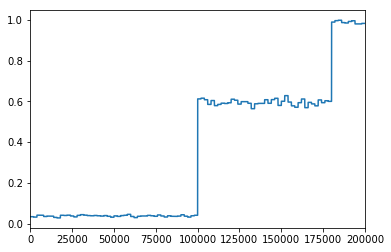

In [139]:
p1_3_scores_agg.plot()

In [140]:
player3.set_epsilon(0)
p1_3_real_game = ttt_game(player1, player3, print_output = False)

In [141]:
for i in range(20000):
    p1_3_real_game.play()
    p1_3_real_game.reset()

In [142]:
p1_3_real_scores = pd.DataFrame(p1_3_real_game.playerO_score)
p1_3_real_scores.columns = ['score']
p1_3_real_scores['not_loss'] = (p1_3_real_scores.score != 0).astype(int)
group_size = 2000
n_groups = len(p1_3_real_scores)/group_size
p1_3_real_scores['group'] = np.repeat(np.arange(n_groups), group_size)
p1_3_real_scores_agg = p1_3_real_scores.groupby('group').not_loss.transform(lambda x: x.sum()/float(x.shape[0]))

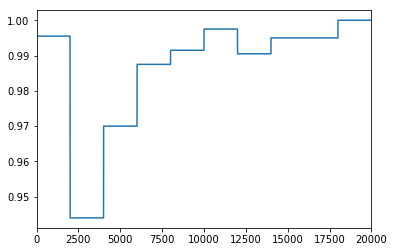

In [144]:
p1_3_real_scores_agg.plot()

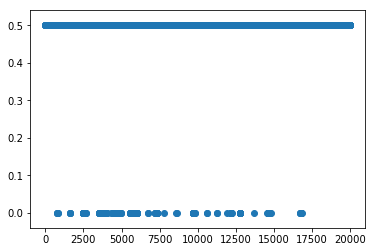

In [145]:
plt.scatter(np.arange(p1_3_real_scores.shape[0]), p1_3_real_scores.score)

### Figure out if Player 3 is buggy

In [74]:
player3 = ttt_player('computer', 'O', epsilon=.9)
game2 = ttt_game('human', player3, print_output = True)

In [84]:
game2.reset()
game2.play()

_ _ _
_ _ _
_ _ _

Player X's turn:
Enter the row and column you want to make a mark in, using the format x,y 1,1
X _ _
_ _ _
_ _ _

Player O's turn:
X _ _
O _ _
_ _ _

Player X's turn:
Enter the row and column you want to make a mark in, using the format x,y 2,2
X _ _
O X _
_ _ _

Player O's turn:
X _ _
O X _
_ O _

Player X's turn:
Enter the row and column you want to make a mark in, using the format x,y 3,3
X _ _
O X _
_ O X

Player X wins!


In [146]:
player3.policy

{('O', 'O', 'X', 'O', 'X', 'X', '_', 'X', 'O'): 0.45,
 ('O', 'O', 'X', 'O', 'X', '_', '_', 'X', '_'): 0.45,
 ('O', 'O', 'X', 'X', 'O', 'O', 'X', 'X', '_'): 0.36450000000000005,
 ('O', 'O', 'X', 'X', 'O', 'O', 'X', '_', 'X'): 0.405,
 ('O', 'O', 'X', 'X', 'O', 'O', '_', 'X', 'X'): 0.45,
 ('O', 'O', 'X', 'X', 'O', 'X', 'O', 'X', '_'): 0.45,
 ('O', 'O', 'X', 'X', 'O', '_', 'O', 'X', 'X'): 0.405,
 ('O', 'O', 'X', 'X', 'O', '_', '_', 'X', '_'): 0.495,
 ('O', 'O', 'X', 'X', 'O', '_', '_', '_', 'X'): 0.45,
 ('O', 'O', 'X', 'X', 'X', 'O', 'O', 'X', '_'): 0.5,
 ('O', 'O', 'X', 'X', 'X', 'O', 'O', '_', 'X'): 0.5,
 ('O', 'O', 'X', 'X', 'X', 'O', '_', 'O', 'X'): 0.45,
 ('O', 'O', 'X', 'X', 'X', 'O', '_', 'X', 'O'): 1.4874809411177089e-80,
 ('O', 'O', 'X', 'X', 'X', 'O', '_', '_', '_'): 0.45,
 ('O', 'O', 'X', 'X', 'X', '_', 'O', 'X', 'O'): 0.405,
 ('O', 'O', 'X', 'X', 'X', '_', 'O', '_', '_'): 0.45,
 ('O', 'O', 'X', 'X', 'X', '_', '_', 'O', '_'): 0.45,
 ('O', 'O', 'X', 'X', 'X', '_', '_', '_', 'O'):

In [156]:
a = player1.policy[('X','_','_','_','_','_','_','_','_')]
b = player1.policy[('_','_','_','_','X','_','_','_','_')]
a > b

True

In [151]:
explore_policy(['_','_','_','_','_','_','_','_','_'], player1)

_ _ _
_ _ _
_ _ _
Initial board state

X _ _
_ _ _
_ _ _
Win probability = 0.50000000006500467

_ X _
_ _ _
_ _ _
Win probability = 0.50000000006032996

_ _ X
_ _ _
_ _ _
Win probability = 0.50000000006617540

_ _ _
X _ _
_ _ _
Win probability = 0.50000000050375748

_ _ _
_ X _
_ _ _
Win probability = 0.50000000006148015

_ _ _
_ _ X
_ _ _
Win probability = 0.50000000006487921

_ _ _
_ _ _
X _ _
Win probability = 0.50000000006544532

_ _ _
_ _ _
_ X _
Win probability = 0.50000000006377066

_ _ _
_ _ _
_ _ X
Win probability = 0.50000000006577427



### What is Player 1's deal?

In [157]:
p1_tim_game = ttt_game(player1, 'human')

In [158]:
p1_tim_game.reset()
p1_tim_game.play()

_ _ _
_ _ _
_ _ _

Player X's turn:
_ _ _
X _ _
_ _ _

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 1,1
O _ _
X _ _
_ _ _

Player X's turn:
O _ _
X _ _
_ _ X

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 1,2
O O _
X _ _
_ _ X

Player X's turn:
O O X
X _ _
_ _ X

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 2,3
O O X
X _ O
_ _ X

Player X's turn:
O O X
X _ O
X _ X

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 3,2
O O X
X _ O
X O X

Player X's turn:
O O X
X X O
X O X

Player X wins!


### Win stats

In [49]:
scores = pd.DataFrame(game.playerO_score)
scores.columns = ['score']
scores['not_loss'] = (scores.score != 0).astype(int)
group_size = 2000
n_groups = len(scores)/group_size
scores['group'] = np.repeat(np.arange(n_groups), group_size)
scores_agg = scores.groupby('group').not_loss.transform(lambda x: x.sum()/float(x.shape[0]))
scores_agg.head()

0    0.027
1    0.027
2    0.027
3    0.027
4    0.027
Name: not_loss, dtype: float64

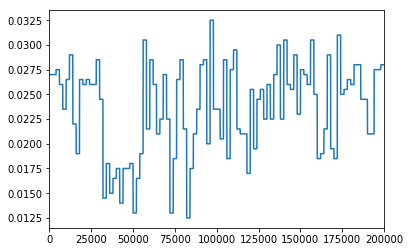

In [50]:
scores_agg.plot()

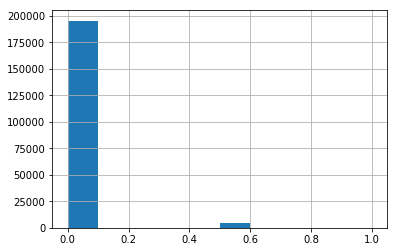

In [51]:
scores.score.hist()

In [56]:
player3.alpha

0.1

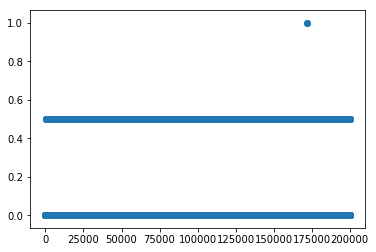

In [17]:
scores = game.playerO_score
n = len(scores)
plt.scatter(np.arange(n), scores)

In [18]:
np.argmax(scores)

171939

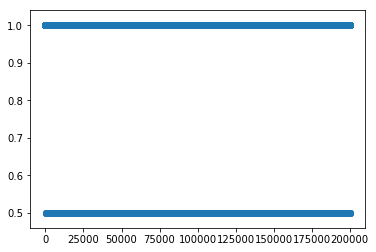

In [19]:
scores_X = game.playerX_score
n = len(scores_X)
plt.scatter(np.arange(n), scores_X)

# Mental Bookmark
- Refactor code so I can do the rest of the testing faster
- X doesn't usually learn the corner as the optimal first move. Why?  
-- Try training for 200k games, check the policy. If corners aren't optimal, train more and see if it helps. If corners are optimal, set alpha = 0 and keep stats on player 3.
- create readme
- create a module that I can import?
- give computer players one policy dictionary to share?  
-- they'll train twice as fast, and have all entries